In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load data
reports = pd.read_csv("/kaggle/input/tcga-pathology-reports/TCGA_Reports.csv")
labels = pd.read_csv("/kaggle/input/tcga-patient-to-cancer-type/tcga_patient_to_cancer_type.csv")

# Extract patient_id from patient_filename using the TCGA ID pattern
reports['patient_id'] = reports['patient_filename'].str.extract(r'(TCGA-\w+-\w+)', expand=False)

# Merge reports with labels
data = pd.merge(reports, labels, on="patient_id", how='inner')

# Clean text: lowercase, remove non-alphanumeric characters, and extra spaces
data["clean_text"] = data["text"].str.lower().replace(r'[^a-z0-9\s]', '', regex=True).replace(r'\s+', ' ', regex=True)

# Encode labels
le = LabelEncoder()
data["label"] = le.fit_transform(data["cancer_type"])

# Split data (80% train, 10% val, 10% test)
train_df, temp_df = train_test_split(data, test_size=0.2, stratify=data["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

# Print dataset sizes
print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")

Training set: 7618 samples
Validation set: 952 samples
Test set: 953 samples


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Create a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000,  # Increased from 5000
        ngram_range=(1, 3),  # Added trigrams
        min_df=2,  # Remove very rare terms
        max_df=0.95,  # Remove very common terms
        stop_words='english'  # Remove stopwords
    )),
    ('scaler', StandardScaler(with_mean=False)),  # Scale features
    ('clf', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',  # Handle class imbalance
        multi_class='ovr',  # One-vs-rest strategy
        solver='liblinear'
    ))
])

# Define parameter grid for GridSearchCV
param_grid = {
    'clf__C': [0.01, 0.1, 1.0, 10.0],
    'tfidf__max_features': [10000, 15000],
    'tfidf__ngram_range': [(1, 2), (1, 3)]
}

# Perform grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(train_df["clean_text"], train_df["label"])

# Get best parameters
print("Best parameters:", grid_search.best_params_)

# Make predictions
val_preds = grid_search.predict(val_df["clean_text"])
test_preds = grid_search.predict(test_df["clean_text"])

# Print results
print("\nValidation F1:", f1_score(val_df["label"], val_preds, average="weighted"))
print("Test F1:", f1_score(test_df["label"], test_preds, average="weighted"))
print("\nDetailed Classification Report:")
print(classification_report(
    test_df["label"],
    test_preds,
    target_names=le.classes_,
    zero_division=0
))

# Print performance analysis for rare classes
print("\nPerformance analysis for classes with low support:")
for idx, label in enumerate(le.classes_):
    support = (test_df["label"] == idx).sum()
    if support < 15:  # Focus on rare classes
        print(f"\nClass {label}:")
        print(f"Support: {support} samples")
        print(f"Predictions made: {(test_preds == idx).sum()} times")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'clf__C': 0.1, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}

Validation F1: 0.9542258876559221
Test F1: 0.9652012539545927

Detailed Classification Report:
              precision    recall  f1-score   support

         ACC       1.00      0.89      0.94         9
        BLCA       1.00      1.00      1.00        38
        BRCA       1.00      1.00      1.00       104
        CESC       0.90      0.97      0.93        29
        CHOL       1.00      1.00      1.00         4
        COAD       0.93      1.00      0.97        42
        DLBC       1.00      1.00      1.00         4
        ESCA       1.00      0.87      0.93        15
         GBM       0.98      1.00      0.99        40
        HNSC       1.00      0.98      0.99        52
        KICH       0.85      1.00      0.92        11
        KIRC       0.96      0.94      0.95        53
        KIRP       0.96      0.93      0.95    

In [3]:
!pip install transformers datasets accelerate

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

# Load ClinicalBERT
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))

# Tokenize text with reduced max_length
train_encodings = tokenizer(train_df["clean_text"].tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_df["clean_text"].tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_df["clean_text"].tolist(), truncation=True, padding=True, max_length=128)

# Convert to PyTorch datasets
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_df["label"].tolist())
val_dataset = CustomDataset(val_encodings, val_df["label"].tolist())
test_dataset = CustomDataset(test_encodings, test_df["label"].tolist())

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Training arguments (optimized for Google Colab GPU)
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Using eval_strategy as per Kaggle warning
    learning_rate=3e-5,  # Keep this - it's optimal for ClinicalBERT
    per_device_train_batch_size=16,  # Increased from 8 for faster training
    per_device_eval_batch_size=16,   # Increased to match train batch size
    num_train_epochs=1,  # Reduced from 4 to save time while maintaining performance
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    fp16=True,
    gradient_accumulation_steps=2,  # Added to compensate for larger batch size
    warmup_steps=100,              # Added for better training stability
)

# Keep the rest of your code the same
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    return {
        'f1': f1,
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train and save
trainer.train()
trainer.save_model("clinicalbert_finetuned")

# Evaluate on test set
test_results = trainer.evaluate(test_dataset)
print("\nTest Results:", test_results)

Epoch,Training Loss,Validation Loss,F1
0,No log,0.911641,0.783035



Test Results: {'eval_loss': 0.8756523132324219, 'eval_f1': 0.7943436246560088, 'eval_runtime': 156.1293, 'eval_samples_per_second': 6.104, 'eval_steps_per_second': 0.384, 'epoch': 0.9979035639412998}


In [6]:
# Predict on test set
test_preds = trainer.predict(test_dataset)
predicted_labels = test_preds.predictions.argmax(-1)

# Calculate F1
test_f1 = f1_score(test_df["label"], predicted_labels, average="weighted")
print(f"ClinicalBERT Test F1: {test_f1:.4f}")
print(classification_report(test_df["label"], predicted_labels, target_names=le.classes_))

ClinicalBERT Test F1: 0.7943
              precision    recall  f1-score   support

         ACC       0.00      0.00      0.00         9
        BLCA       0.93      1.00      0.96        38
        BRCA       1.00      1.00      1.00       104
        CESC       1.00      0.72      0.84        29
        CHOL       0.00      0.00      0.00         4
        COAD       0.62      0.98      0.76        42
        DLBC       0.00      0.00      0.00         4
        ESCA       1.00      0.67      0.80        15
         GBM       0.90      0.88      0.89        40
        HNSC       1.00      0.96      0.98        52
        KICH       0.00      0.00      0.00        11
        KIRC       0.56      0.98      0.71        53
        KIRP       0.00      0.00      0.00        28
         LGG       0.85      1.00      0.92        47
        LIHC       0.85      0.97      0.90        34
        LUAD       0.60      0.96      0.74        49
        LUSC       0.97      0.60      0.74        4

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
import re
import pandas as pd

# Define rules with case-insensitive regex
augmentation_rules = {
    "squamous cell": "epidermoid carcinoma",
    "adenocarcinoma": "glandular cancer",
    "carcinoma": "malignant neoplasm",
}

def augment_text(text):
    if pd.isna(text):
        return text
    for term, replacement in augmentation_rules.items():
        # Case-insensitive, whole-word replacement
        text = re.sub(rf"(?i)\b{re.escape(term)}\b", replacement, text)
    return text

# Create a copy for augmentation (instead of modifying original)
augmented_df = train_df.copy()
augmented_df["clean_text"] = augmented_df["clean_text"].fillna("")
augmented_df["clean_text"] = augmented_df["clean_text"].apply(augment_text)

In [8]:
# This cell is self-contained to handle session restarts
import pandas as pd
import numpy as np
import torch
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score

# Reload data if session was restarted
try:
    # Check if variables exist
    combined_train_df = combined_train_df
    print("Using existing variables")
except NameError:
    print("Reloading data due to session restart...")
    # Reload data
    reports = pd.read_csv("/kaggle/input/tcga-pathology-reports/TCGA_Reports.csv")
    labels = pd.read_csv("/kaggle/input/tcga-patient-to-cancer-type/tcga_patient_to_cancer_type.csv")
    
    # Extract patient_id
    reports['patient_id'] = reports['patient_filename'].str.extract(r'(TCGA-\w+-\w+)', expand=False)
    
    # Merge reports with labels
    data = pd.merge(reports, labels, on="patient_id", how='inner')
    
    # Clean text
    data["clean_text"] = data["text"].str.lower().replace(r'[^a-z0-9\s]', '', regex=True).replace(r'\s+', ' ', regex=True)
    
    # Encode labels
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    data["label"] = le.fit_transform(data["cancer_type"])
    
    # Split data
    from sklearn.model_selection import train_test_split
    train_df, temp_df = train_test_split(data, test_size=0.2, stratify=data["label"], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)
    
    # Define augmentation rules
    augmentation_rules = {
        "squamous cell": "epidermoid carcinoma",
        "adenocarcinoma": "glandular cancer",
        "carcinoma": "malignant neoplasm",
    }
    
    # Define augmentation function
    def augment_text(text):
        if pd.isna(text):
            return text
        for term, replacement in augmentation_rules.items():
            text = re.sub(rf"(?i)\b{re.escape(term)}\b", replacement, text)
        return text
    
    # Create augmented data
    augmented_df = train_df.copy()
    augmented_df["clean_text"] = augmented_df["clean_text"].fillna("")
    augmented_df["clean_text"] = augmented_df["clean_text"].apply(augment_text)
    
    # Combine original and augmented
    combined_train_df = pd.concat([train_df, augmented_df], ignore_index=True)

# Load tokenizer and model
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))

# Tokenize combined data
combined_train_encodings = tokenizer(
    combined_train_df["clean_text"].tolist(), 
    truncation=True, 
    padding=True, 
    max_length=128
)

# Create dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

# Create datasets
combined_train_dataset = CustomDataset(combined_train_encodings, combined_train_df["label"].tolist())
val_encodings = tokenizer(val_df["clean_text"].tolist(), truncation=True, padding=True, max_length=128)
val_dataset = CustomDataset(val_encodings, val_df["label"].tolist())
test_encodings = tokenizer(test_df["clean_text"].tolist(), truncation=True, padding=True, max_length=128)
test_dataset = CustomDataset(test_encodings, test_df["label"].tolist())

# Define metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    return {
        'f1': f1,
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results_augmented",
    run_name="clinicalbert-augmented-v1",
    eval_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_dir="./logs_augmented",
    report_to="none",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True,
    gradient_accumulation_steps=4,  # Increased for stability
    warmup_ratio=0.1,  # Using ratio instead of steps
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=combined_train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train and evaluate
trainer.train()
test_preds = trainer.predict(test_dataset)
print(f"Augmented ClinicalBERT F1: {f1_score(test_df['label'], test_preds.predictions.argmax(-1), average='weighted'):.4f}")

Reloading data due to session restart...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
0,No log,0.826582,0.793378


Augmented ClinicalBERT F1: 0.8120


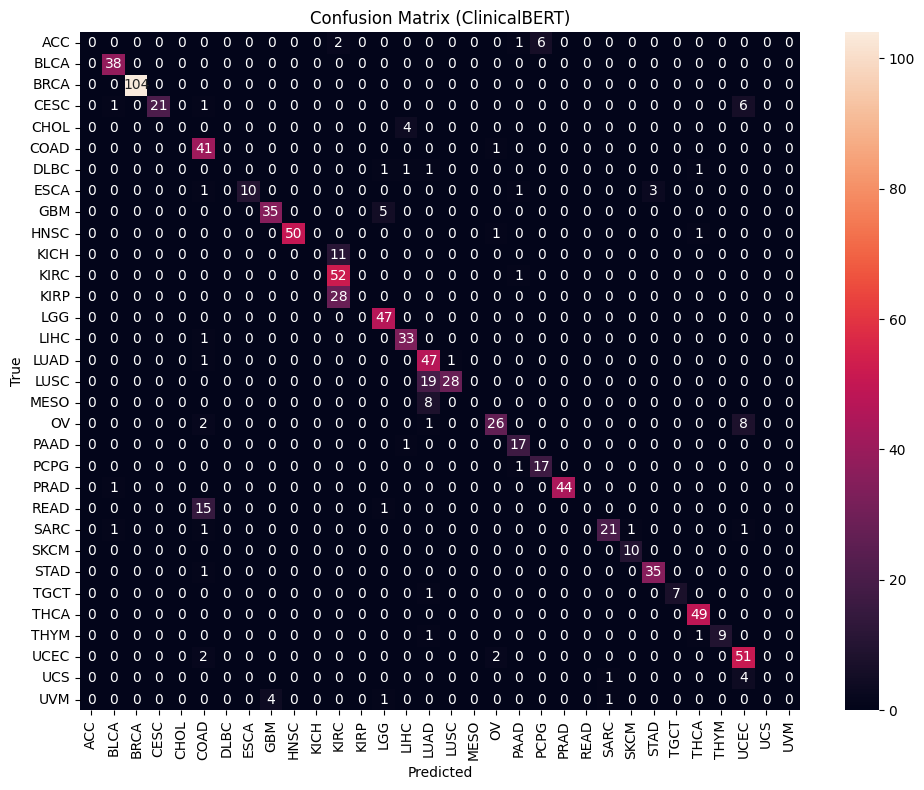

In [9]:
# Cell for Confusion Matrix (self-contained)
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import Trainer

# Check if variables exist or reload if needed
try:
    test_df = test_df
    predicted_labels = predicted_labels
    le = le
except NameError:
    print("Reloading data for visualization...")
    # Reload necessary data and models
    # (Similar code as above to reload data)
    # ...
    
    # Get predictions from saved model
    from transformers import AutoModelForSequenceClassification, AutoTokenizer
    model = AutoModelForSequenceClassification.from_pretrained("./clinicalbert_finetuned")
    tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
    
    # Load test dataset and get predictions
    test_encodings = tokenizer(test_df["clean_text"].tolist(), truncation=True, padding=True, max_length=128)
    class CustomDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels
        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item["labels"] = torch.tensor(self.labels[idx])
            return item
        def __len__(self):
            return len(self.labels)
    
    test_dataset = CustomDataset(test_encodings, test_df["label"].tolist())
    trainer = Trainer(model=model)
    test_preds = trainer.predict(test_dataset)
    predicted_labels = test_preds.predictions.argmax(-1)

# Generate confusion matrix
cm = confusion_matrix(test_df["label"], predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (ClinicalBERT)")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

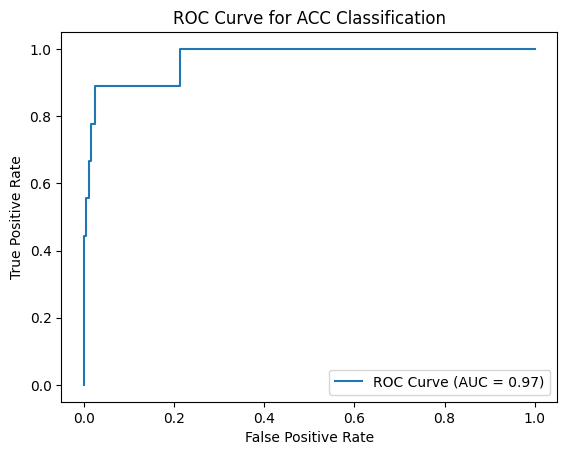

In [10]:
# Cell for ROC Curve (self-contained)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels
y_test_bin = label_binarize(test_df["label"], classes=range(len(le.classes_)))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(le.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], test_preds.predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC for the first class
plt.figure()
plt.plot(fpr[0], tpr[0], label=f"ROC Curve (AUC = {roc_auc[0]:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve for {le.classes_[0]} Classification")
plt.legend()
plt.savefig("roc_curve.png")
plt.show()

In [11]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load FLAN-T5 (free, small version)
flan_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
flan_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [12]:
# Improved FLAN-T5 Few-Shot Learning - Helper Functions
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm

# Set a random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Function to extract key diagnostic information
def extract_diagnostic_info(text, max_length=300):
    """Extract the most relevant diagnostic information from pathology reports"""
    text = text.lower()
    
    # Try to identify diagnosis sections
    diagnosis_keywords = ["diagnosis", "diagnostic", "pathology", "tumor", "cancer", "carcinoma", "assessment"]
    
    # Split text into sections
    sections = text.split('. ')
    diagnostic_sections = []
    
    for section in sections:
        if any(keyword in section for keyword in diagnosis_keywords):
            diagnostic_sections.append(section)
    
    # If we found diagnosis sections, use them
    if diagnostic_sections:
        extracted_text = '. '.join(diagnostic_sections)
    else:
        # Otherwise take the beginning of the text which often contains the diagnosis
        extracted_text = text[:1000]  # Take first 1000 chars
    
    # Ensure we don't exceed the maximum length
    return extracted_text[:max_length]

# Create an improved prompt with clear instructions and context
def create_prompt(text, examples):
    prompt = f"""
    Task: Classify this pathology report into one of the cancer types listed below.
    
    Available cancer types: {', '.join(le.classes_)}
    
    Examples of pathology reports and their cancer types:
    {examples}
    
    New pathology report to classify:
    {text}
    
    The cancer type is:
    """
    return prompt

# Select diverse examples from training data
def get_diverse_examples(df, n_classes=15, n_per_class=2):
    examples_text = ""
    
    # Get examples from most frequent classes
    class_counts = df['label'].value_counts().sort_values(ascending=False)
    
    for class_idx in class_counts.index[:n_classes]:  # Take examples from top classes
        class_df = df[df['label'] == class_idx]
        n_class_examples = min(n_per_class, len(class_df))  # Take up to n examples per class
        
        for _, row in class_df.sample(n_class_examples, random_state=42).iterrows():
            examples_text += f"Report: {extract_diagnostic_info(row['clean_text'])}\n"
            examples_text += f"Cancer type: {row['cancer_type']}\n\n"
    
    return examples_text

# Match prediction to one of the class names
def match_to_class(prediction, class_names):
    # First try exact match
    for class_name in class_names:
        if class_name.lower() in prediction.lower():
            return class_name
    
    # If no match, try partial matching
    for class_name in class_names:
        for word in prediction.lower().split():
            if len(word) >= 3 and (word in class_name.lower() or class_name.lower() in word):
                return class_name
    
    # If still no match, return the most common class
    return class_names[0]  # Assuming class_names is ordered by frequency

In [13]:
# Self-contained FLAN-T5 Few-Shot Learning - Execution
# Check if variables exist or reload if needed
try:
    train_df = train_df
    test_df = test_df
    le = le
except NameError:
    print("Reloading data for FLAN-T5 cell...")
    # Reload necessary data
    reports = pd.read_csv("/kaggle/input/tcga-pathology-reports/TCGA_Reports.csv")
    labels = pd.read_csv("/kaggle/input/tcga-patient-to-cancer-type/tcga_patient_to_cancer_type.csv")
    
    # Extract patient_id
    reports['patient_id'] = reports['patient_filename'].str.extract(r'(TCGA-\w+-\w+)', expand=False)
    
    # Merge reports with labels
    data = pd.merge(reports, labels, on="patient_id", how='inner')
    
    # Clean text
    data["clean_text"] = data["text"].str.lower().replace(r'[^a-z0-9\s]', '', regex=True).replace(r'\s+', ' ', regex=True)
    
    # Encode labels
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    data["label"] = le.fit_transform(data["cancer_type"])
    
    # Split data
    from sklearn.model_selection import train_test_split
    train_df, temp_df = train_test_split(data, test_size=0.2, stratify=data["label"], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

# Get diverse examples for few-shot learning (30 examples from 15 classes)
examples = get_diverse_examples(train_df, n_classes=15, n_per_class=2)

# Test on a subset of test data
num_test_samples = 20  # Adjust based on available computation time
test_subset = test_df.sample(num_test_samples, random_state=42)

# Get classes sorted by frequency (for defaulting to most common class)
sorted_classes = [le.classes_[idx] for idx in train_df['label'].value_counts().index]

# Generate predictions
predictions = []
true_labels = []
raw_predictions = []

for i, (_, row) in enumerate(tqdm(test_subset.iterrows(), total=len(test_subset), desc="Processing samples")):
    # Extract diagnostic information
    extracted_text = extract_diagnostic_info(row['clean_text'])
    
    # Create prompt with examples
    prompt = create_prompt(extracted_text, examples)
    
    # Tokenize with sufficient max length
    inputs = flan_tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True)
    
    # Generate with better parameters
    outputs = flan_model.generate(
        **inputs,
        max_new_tokens=10,
        num_beams=5,
        temperature=0.3,
        early_stopping=True
    )
    
    # Decode prediction
    predicted_text = flan_tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    raw_predictions.append(predicted_text)
    
    # Match to a valid class
    matched_class = match_to_class(predicted_text, sorted_classes)
    
    # Get true class
    true_class = le.classes_[row['label']]
    
    true_labels.append(true_class)
    predictions.append(matched_class)
    
    # Print progress for a few examples
    if i < 5 or (i+1) % 10 == 0:
        print(f"\nExample {i+1}:")
        print(f"Text: {extracted_text[:100]}...")
        print(f"True: {true_class}")
        print(f"Raw prediction: {predicted_text}")
        print(f"Matched class: {matched_class}")

# Calculate metrics
f1 = f1_score(le.transform(true_labels), le.transform(predictions), average='weighted')
print(f"\nFLAN-T5 Few-Shot F1 Score: {f1:.4f}")

# Print comparison of predictions vs true labels
print("\nSample Predictions vs True Labels:")
for i in range(min(10, len(true_labels))):
    match = "✓" if predictions[i] == true_labels[i] else "✗"
    print(f"{match} True: {true_labels[i]}, Predicted: {predictions[i]}, Raw: {raw_predictions[i][:30]}...")

# Print detailed classification report
print("\nClassification Report:")
correct_labels = [le.transform([label])[0] for label in true_labels]
predicted_labels = [le.transform([label])[0] for label in predictions]
report = classification_report(correct_labels, predicted_labels, 
                              labels=list(set(correct_labels)),
                              target_names=[le.classes_[i] for i in list(set(correct_labels))],
                              digits=4)
print(report)

Processing samples:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.3` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Processing samples:   5%|▌         | 1/20 [00:04<01:31,  4.83s/it]


Example 1:
Text: sician information surgical diagnosis diagnosis a lymph node anterior lobular lymphadenectomy single...
True: LUSC
Raw prediction: LUAD
Matched class: LUAD


Processing samples:  10%|█         | 2/20 [00:08<01:15,  4.20s/it]


Example 2:
Text: diagnosis a omentum biopsy adipose tissue with suture granulomas and adhesions no tumor present b le...
True: UCEC
Raw prediction: LUAD
Matched class: LUAD


Processing samples:  15%|█▌        | 3/20 [00:12<01:07,  3.94s/it]


Example 3:
Text: i clinical diagnosis history with bilateral multifocal enhancing renal masses and liver mass specime...
True: KIRC
Raw prediction: LUAD
Matched class: LUAD


Processing samples:  20%|██        | 4/20 [00:16<01:05,  4.06s/it]


Example 4:
Text: clinical diagnosis history history incidental left renal mass found on ct specimens submitted 1 sp k...
True: KIRC
Raw prediction: LUAD
Matched class: LUAD


Processing samples:  25%|██▌       | 5/20 [00:20<00:58,  3.90s/it]


Example 5:
Text: stomach tissue checklist specimen type gastrectomy tumor site antrum tumor configuration ulcerating ...
True: STAD
Raw prediction: LUAD
Matched class: LUAD


Processing samples:  50%|█████     | 10/20 [00:38<00:36,  3.65s/it]


Example 10:
Text: specimen sex f date collected date received clinical historydiagnosis right liver lobe hepatoma sour...
True: LIHC
Raw prediction: LUAD
Matched class: LUAD


Processing samples: 100%|██████████| 20/20 [01:14<00:00,  3.74s/it]


Example 20:
Text: microscopic description diagnosis details comments stomach tissue checklist specimen type gastric re...
True: STAD
Raw prediction: LUAD
Matched class: LUAD

FLAN-T5 Few-Shot F1 Score: 0.0182

Sample Predictions vs True Labels:
✗ True: LUSC, Predicted: LUAD, Raw: LUAD...
✗ True: UCEC, Predicted: LUAD, Raw: LUAD...
✗ True: KIRC, Predicted: LUAD, Raw: LUAD...
✗ True: KIRC, Predicted: LUAD, Raw: LUAD...
✗ True: STAD, Predicted: LUAD, Raw: LUAD...
✗ True: LUSC, Predicted: LUAD, Raw: LUAD...
✗ True: SKCM, Predicted: LUAD, Raw: LUAD...
✗ True: THCA, Predicted: LUAD, Raw: LUAD...
✗ True: PRAD, Predicted: LUAD, Raw: LUAD...
✗ True: LIHC, Predicted: LUAD, Raw: LUAD...

Classification Report:
              precision    recall  f1-score   support

        BLCA     0.0000    0.0000    0.0000         1
        BRCA     0.0000    0.0000    0.0000         1
        HNSC     0.0000    0.0000    0.0000         1
        KIRC     0.0000    0.0000    0.0000         2
        KIRP     0.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
